## ⚠️ Before you run this notebook
Please make sure that:
* The file **`ERC20-stablecoins.zip`** is located in the data directory as this notebook
* You have sufficient memory available to load large CSV files in chunks if needed

You do **not** need to manually unzip the file.

## 📦 Importing Required Library
We begin by importing a few standard Python libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import zipfile
import io
import pandas as pd



#  Transactional data



## file opening & basic cleaning

In [2]:
contract_mapping = {
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'DAI',
    '0x8e870d67f660d95d5be530380d0ec0bd388289e1': 'PAX',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC',
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT',
    '0xa47c8bf37f92abed4a126bda807a7b7498661acd': 'USTC',
    '0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9': 'WLUNA'
}

with zipfile.ZipFile("data/ERC20-stablecoins.zip") as z:
    with z.open("token_transfers.csv") as f:
        TT1 = pd.read_csv(f)
        #convert datetime
        TT1['datetime'] = pd.to_datetime(TT1['time_stamp'], unit='s')
        #change address to coin name
        TT1['coin_name'] = TT1['contract_address'].map(contract_mapping)
        TT1.drop(columns=['contract_address','time_stamp'], inplace=True)

    with z.open("token_transfers_V2.0.0.csv") as f:
        TT2 = pd.read_csv(f)
        #convert datetime
        TT2['datetime'] = pd.to_datetime(TT2['time_stamp'], unit='s')
        #change address to coin name
        TT2['coin_name'] = TT2['contract_address'].map(contract_mapping)
        TT2.drop(columns=['contract_address','time_stamp'], inplace=True)

    with z.open("token_transfers_V3.0.0.csv") as f:
        TT3 = pd.read_csv(f)
        #convert datetime
        TT3['datetime'] = pd.to_datetime(TT3['time_stamp'], unit='s')
        #change address to coin name
        TT3['coin_name'] = TT3['contract_address'].map(contract_mapping)
        TT3.drop(columns=['contract_address','time_stamp'], inplace=True)
print("Data transformation complete. Preview:")
print(TT1[['datetime', 'coin_name', 'value']].head())
print(TT2[['datetime', 'coin_name', 'value']].head())
print(TT3[['datetime', 'coin_name', 'value']].head())

Data transformation complete. Preview:
             datetime coin_name         value
0 2022-04-28 00:30:15      USDT     18.670000
1 2022-04-28 00:30:15      USDT  10000.000000
2 2022-04-28 00:30:15      USDT   9942.313005
3 2022-04-28 00:30:15      USDT    234.364097
4 2022-04-28 00:30:15      USDT   9800.000000
             datetime coin_name         value
0 2022-04-28 00:30:15      USDT     18.670000
1 2022-04-28 00:30:15      USDT  10000.000000
2 2022-04-28 00:30:15      USDT   9942.313005
3 2022-04-28 00:30:15      USDT    234.364097
4 2022-04-28 00:30:15      USDT   9800.000000
             datetime coin_name         value
0 2022-04-01 11:10:21      USDT    800.000000
1 2022-04-01 11:10:21      USDT    579.000000
2 2022-04-01 11:10:21      USDT  15898.000000
3 2022-04-01 11:10:21      USDT    200.929675
4 2022-04-01 11:10:24      USDT    651.675449


## Data cleaning function

In [3]:
def clean_and_diagnose(df):
    print("--- 1. Checking for Null Values ---")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0] if null_counts.any() else "No missing values found.")

    print("\n--- 2. Checking for Duplicate Transactions ---")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")
    # Tip: In blockchain data, duplicates are rare but can happen if the scraper double-recorded a block.
    df = df.drop_duplicates()

    print("\n--- 3. Value Abnormalities (The 'Value' Column) ---")
    # Check for negative values (impossible in standard ERC20 transfers)
    neg_values = (df['value'] < 0).sum()
    # Check for zero values (often "Approval" events or contract interactions, not actual fund moves)
    zero_values = (df['value'] == 0).sum()

    print(f"Negative values: {neg_values}")
    print(f"Zero-value transfers: {zero_values}")
    df = df[df['value'] != 0]

    print("\n--- 4. Address Integrity ---")
    # Check if addresses are missing the '0x' prefix or are the wrong length
    invalid_from = df[~df['from_address'].str.startswith('0x', na=False)]
    invalid_to = df[~df['to_address'].str.startswith('0x', na=False)]
    print(f"Malformed 'from' addresses: {len(invalid_from)}")
    print(f"Malformed 'to' addresses: {len(invalid_to)}")

    return df


## data cleaning

In [4]:
TT1A = clean_and_diagnose(TT1)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 998

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 2750

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


In [5]:
TT2A = clean_and_diagnose(TT2)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 10779

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 16728

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


In [6]:
TT3A = clean_and_diagnose(TT3)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 12521

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 21757

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


## Merging cleaned dataframes

In [45]:
TTA = pd.concat([TT1A, TT2A, TT3A], ignore_index=True)

## cleaning the merged df to remove duplicates

In [46]:
TTAC = clean_and_diagnose(TTA)
#8min run time

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 33923387

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 0

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


## Analysis of total value(amount) of a coin's transactions withn each hour/day over time

### daily ver

In [47]:
# 4. daily Aggregation
# We group by the datetime (rounded to the day) and the coin name
daily_df = TTAC.groupby([pd.Grouper(key='datetime', freq='D'), 'coin_name'])['value'].sum().reset_index()

# Rename columns for clarity
daily_df.rename(columns={'value': 'total_volume_transferred'}, inplace=True)
print(daily_df)

       datetime coin_name  total_volume_transferred
0    2022-04-01       DAI              5.279960e+08
1    2022-04-01       PAX              6.818257e+07
2    2022-04-01      USDC              5.998725e+09
3    2022-04-01      USDT              3.112786e+09
4    2022-04-01      USTC              3.633266e+08
...         ...       ...                       ...
1285 2022-11-01       PAX              6.157633e+07
1286 2022-11-01      USDC              3.434063e+09
1287 2022-11-01      USDT              8.262937e+08
1288 2022-11-01      USTC              3.898207e+05
1289 2022-11-01     WLUNA              5.083086e+08

[1290 rows x 3 columns]


#### Plot graph over all datetime

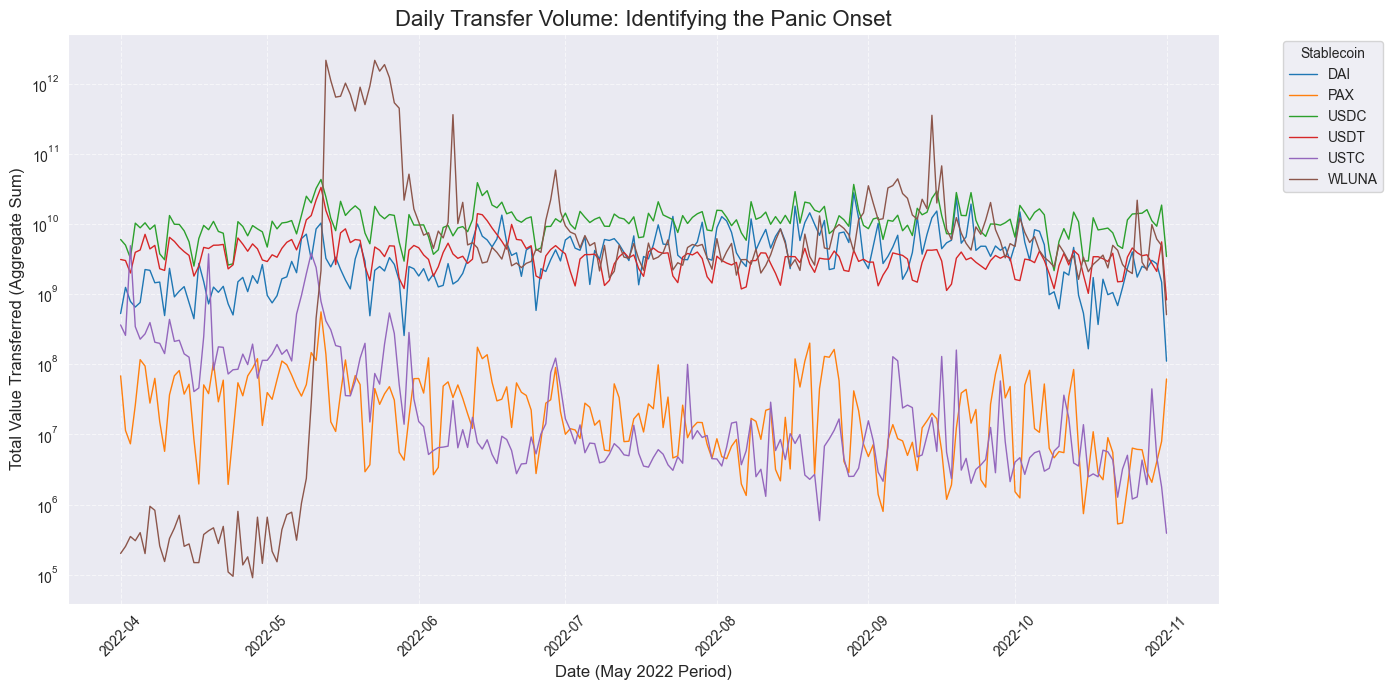

In [49]:
pivotD_df = daily_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivotD_df.columns:
    plt.plot(pivotD_df.index, pivotD_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Daily Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()

#### Zoomed in on May

(np.float64(19113.0), np.float64(19142.0))

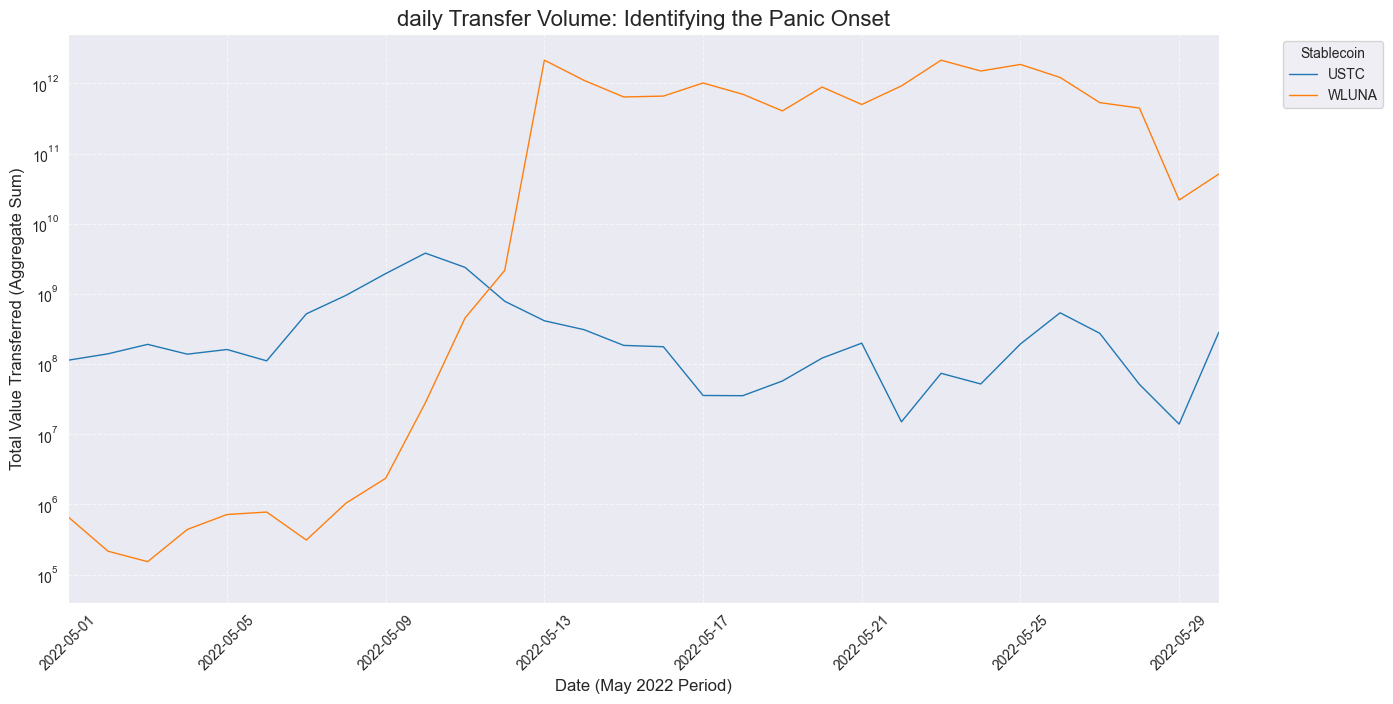

In [50]:
pivotD_df = daily_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivotD_df.columns:
    if coin_name == 'USTC' or coin_name == 'WLUNA':
        plt.plot(pivotD_df.index, pivotD_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('daily Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-01 00:00:00'), pd.Timestamp('2022-05-30 00:00:00'))

### hourly ver

In [52]:
# 4. Hourly Aggregation
# We group by the datetime (rounded to the hour) and the coin name
hourly_df = TTAC.groupby([pd.Grouper(key='datetime', freq='h'), 'coin_name'])['value'].sum().reset_index()

# Rename columns for clarity
hourly_df.rename(columns={'value': 'total_volume_transferred'}, inplace=True)
print(hourly_df)

                 datetime coin_name  total_volume_transferred
0     2022-04-01 11:00:00       DAI              2.174219e+07
1     2022-04-01 11:00:00       PAX              6.364146e+05
2     2022-04-01 11:00:00      USDC              2.282559e+08
3     2022-04-01 11:00:00      USDT              3.871481e+08
4     2022-04-01 11:00:00      USTC              1.058221e+07
...                   ...       ...                       ...
30623 2022-11-01 04:00:00       PAX              3.318194e+04
30624 2022-11-01 04:00:00      USDC              4.702541e+08
30625 2022-11-01 04:00:00      USDT              1.745930e+08
30626 2022-11-01 04:00:00      USTC              1.553252e+05
30627 2022-11-01 04:00:00     WLUNA              2.665641e+07

[30628 rows x 3 columns]


#### Plot graph over all datetimes

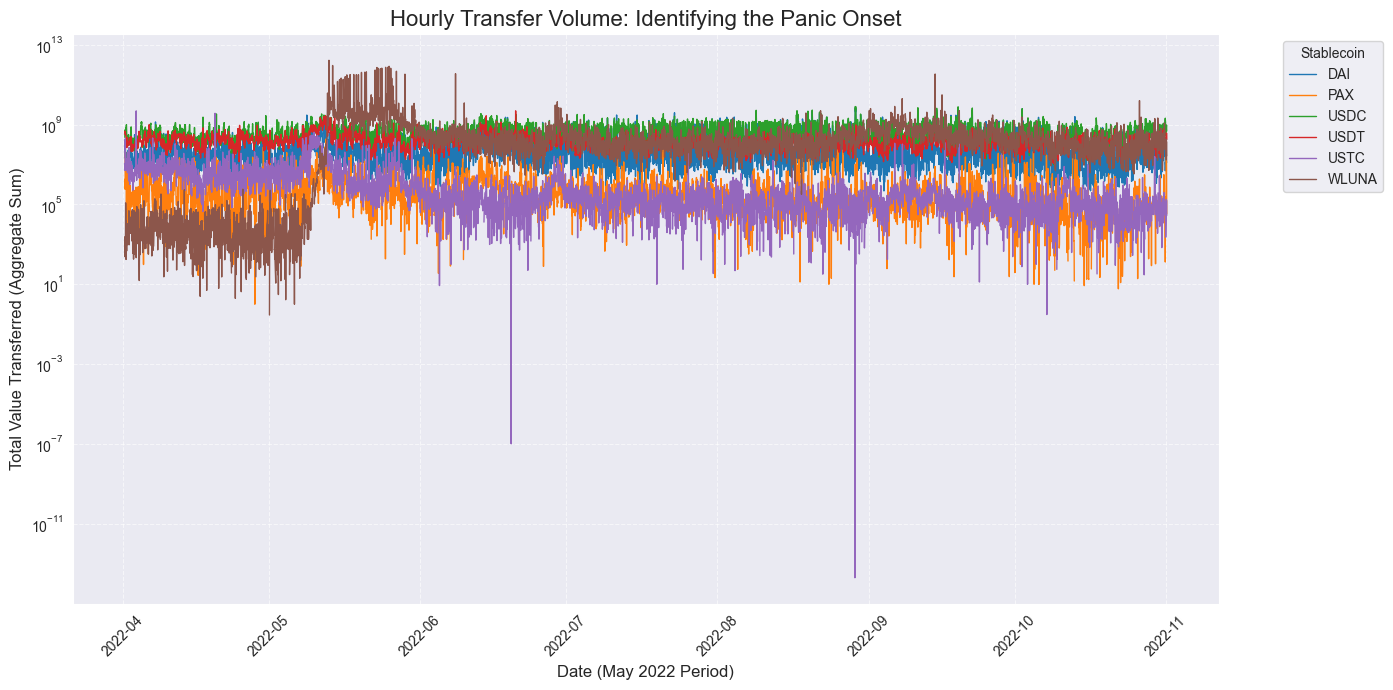

In [53]:
pivot_df = hourly_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Hourly Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()

#### Zoomed in on May

(np.float64(19120.0), np.float64(19132.0))

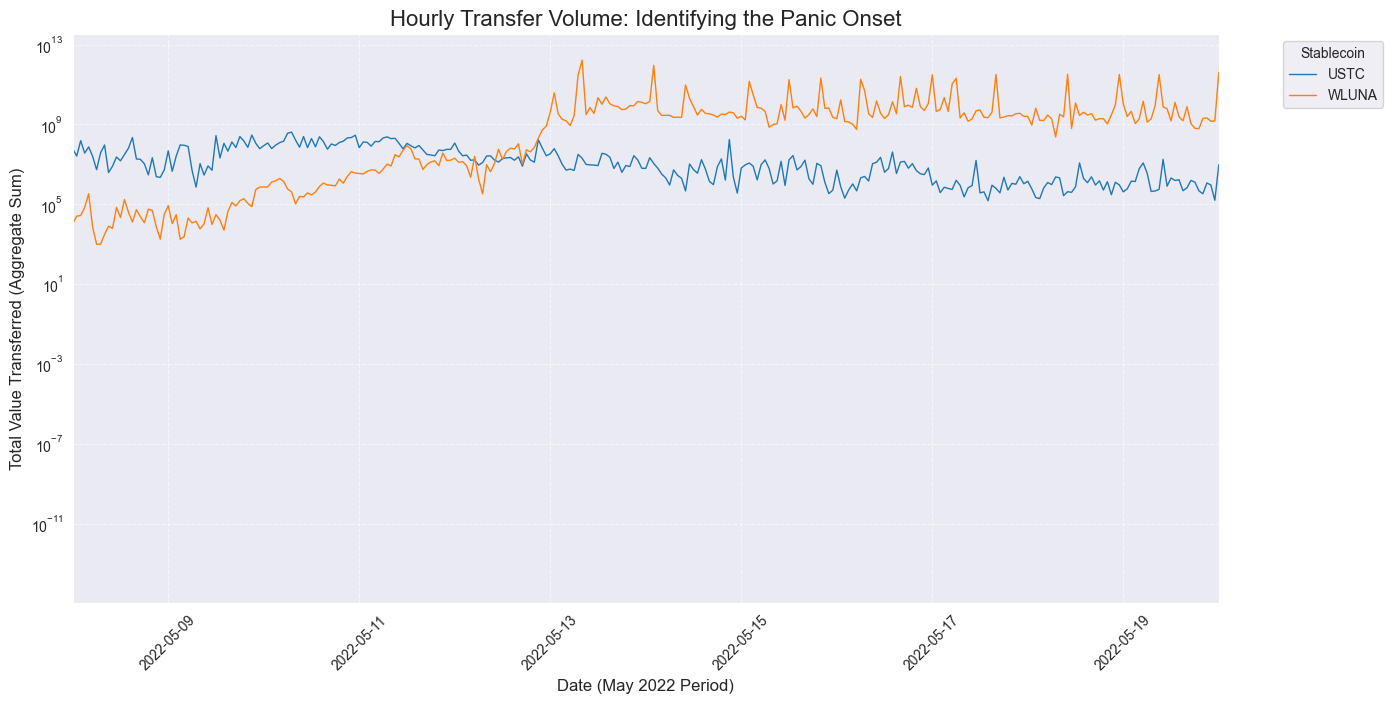

In [15]:
pivot_df = hourly_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivot_df.columns:
    if coin_name == 'USTC' or coin_name == 'WLUNA':
        plt.plot(pivot_df.index, pivot_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Hourly Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))

# Price

## file opening

In [16]:
with zipfile.ZipFile("data/ERC20-stablecoins.zip") as outer_zip:
    nested_zip = outer_zip.read("price_data.zip")
    # Open the nested zip
    with zipfile.ZipFile(io.BytesIO(nested_zip)) as inner_zip:
        # Open the CSV from the nested zip
        with inner_zip.open("price_data/dai_price_data.csv") as f:
            DAIP = pd.read_csv(f)
        with inner_zip.open("price_data/pax_price_data.csv") as f:
            PAXP = pd.read_csv(f)
        with inner_zip.open("price_data/usdc_price_data.csv") as f:
            USDCP = pd.read_csv(f)
        with inner_zip.open("price_data/usdt_price_data.csv") as f:
            USDTP = pd.read_csv(f)
        with inner_zip.open("price_data/ustc_price_data.csv") as f:
            USTCP = pd.read_csv(f)
        with inner_zip.open("price_data/wluna_price_data.csv") as f:
            WLUP = pd.read_csv(f)

## merge into a single dataframe

In [17]:
# List of your dataframes and their corresponding names
dfs = [DAIP, PAXP, USDCP, USDTP, USTCP, WLUP]
names = ['DAI', 'PAX', 'USDC', 'USDT', 'USTC', 'WLUNA']

# Add the coin name to each dataframe
for df, name in zip(dfs, names):
    df['coin_name'] = name

# Stack them into one master dataframe
all_prices = pd.concat(dfs, ignore_index=True)
print(all_prices)

       timestamp      open      high       low     close coin_name
0     1648857600  0.999900  1.000000  0.998900  1.000000       DAI
1     1648944000  1.000000  1.000000  0.998900  0.999000       DAI
2     1649030400  0.999000  1.000000  0.998900  0.999500       DAI
3     1649116800  0.999400  1.000000  0.998700  0.999900       DAI
4     1649203200  0.999900  1.000000  0.998800  0.999100       DAI
...          ...       ...       ...       ...       ...       ...
1285  1667001600  0.000239  0.000252  0.000235  0.000241     WLUNA
1286  1667088000  0.000241  0.000249  0.000229  0.000236     WLUNA
1287  1667174400  0.000236  0.000268  0.000230  0.000244     WLUNA
1288  1667260800  0.000244  0.000255  0.000233  0.000236     WLUNA
1289  1667347200  0.000236  0.000242  0.000210  0.000218     WLUNA

[1290 rows x 6 columns]


## data cleaning function

In [18]:
def clean_price_data(dfO):
    df = dfO.copy()

    print("--- 1. Checking for Null Values ---")
    null_counts = df.isnull().sum()
    if (null_counts > 0).any():
        print(null_counts[null_counts > 0])
    else:
        print("No missing values found.")

    print("\n--- 2. Removing unusable rows with missing OHLC ---")
    before = len(df)
    df = df.dropna(subset=['open','high','low','close'])
    print(f"Rows dropped due to missing OHLC: {before - len(df)}")

    print("\n--- 3. Checking for Duplicate Transactions ---")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")

    df = df.drop_duplicates(subset=['timestamp','coin_name'], keep='last')
    df = df.sort_values(['coin_name','timestamp'])

    # Forward-fill small gaps within each coin
    df[['open','high','low','close']] = (
        df
        .groupby('coin_name')[['open','high','low','close']]
        .ffill()
    )

    print("\n--- 4. Checking for Abnormal Values ---")

    zero_prices = ((df['close'] <= 0) | (df['open'] <= 0)).sum()
    print(f"Zero or negative prices found: {zero_prices}")

    invalid_spread_mask = ~(
        (df['high'] >= df['low']) &
        (df['high'] >= df[['open','close']].max(axis=1)) &
        (df['low'] <= df[['open','close']].min(axis=1))
    )

    print(f"Invalid OHLC spreads found: {invalid_spread_mask.sum()}")

    df = df.loc[
        (df['close'] > 0) &
        (df['open'] > 0) &
        ~invalid_spread_mask
    ]

    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

    return df


## data cleaning

In [19]:
APC = clean_price_data(all_prices)
print (APC)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Removing unusable rows with missing OHLC ---
Rows dropped due to missing OHLC: 0

--- 3. Checking for Duplicate Transactions ---
Duplicate rows found: 0

--- 4. Checking for Abnormal Values ---
Zero or negative prices found: 0
Invalid OHLC spreads found: 0
       timestamp      open      high       low     close coin_name   datetime
0     1648857600  0.999900  1.000000  0.998900  1.000000       DAI 2022-04-02
1     1648944000  1.000000  1.000000  0.998900  0.999000       DAI 2022-04-03
2     1649030400  0.999000  1.000000  0.998900  0.999500       DAI 2022-04-04
3     1649116800  0.999400  1.000000  0.998700  0.999900       DAI 2022-04-05
4     1649203200  0.999900  1.000000  0.998800  0.999100       DAI 2022-04-06
...          ...       ...       ...       ...       ...       ...        ...
1285  1667001600  0.000239  0.000252  0.000235  0.000241     WLUNA 2022-10-29
1286  1667088000  0.000241  0.000249  0.000229  0.

## add column interday range(high-low)

In [20]:
APC["intraday range"]=APC["high"]-APC["low"]
print(APC)

       timestamp      open      high       low     close coin_name   datetime  \
0     1648857600  0.999900  1.000000  0.998900  1.000000       DAI 2022-04-02   
1     1648944000  1.000000  1.000000  0.998900  0.999000       DAI 2022-04-03   
2     1649030400  0.999000  1.000000  0.998900  0.999500       DAI 2022-04-04   
3     1649116800  0.999400  1.000000  0.998700  0.999900       DAI 2022-04-05   
4     1649203200  0.999900  1.000000  0.998800  0.999100       DAI 2022-04-06   
...          ...       ...       ...       ...       ...       ...        ...   
1285  1667001600  0.000239  0.000252  0.000235  0.000241     WLUNA 2022-10-29   
1286  1667088000  0.000241  0.000249  0.000229  0.000236     WLUNA 2022-10-30   
1287  1667174400  0.000236  0.000268  0.000230  0.000244     WLUNA 2022-10-31   
1288  1667260800  0.000244  0.000255  0.000233  0.000236     WLUNA 2022-11-01   
1289  1667347200  0.000236  0.000242  0.000210  0.000218     WLUNA 2022-11-02   

      intraday range  
0   

## create piviot table by coins

In [21]:
# 1. Create a pivot table for Closing Prices
# This is used to visualize the "Death Spiral" of USTC and WLUNA
volatilit_pivot = APC.pivot(index='datetime', columns='coin_name', values='close')

# 2. Create a pivot table for Intraday Range
# This identifies periods of high stress and automated arbitrage failure
volatility_pivot = APC.pivot(index='datetime', columns='coin_name', values='intraday range')


print("Price Pivot Table Preview:")
print(volatilit_pivot.head())

print("intraday range Pivot Table Preview:")
print(volatility_pivot.head())

Price Pivot Table Preview:
coin_name      DAI     PAX    USDC  USDT    USTC   WLUNA
datetime                                                
2022-04-02  1.0000  1.0000  0.9999   1.0  1.0000  105.87
2022-04-03  0.9990  1.0000  0.9993   1.0  1.0000  115.49
2022-04-04  0.9995  1.0000  1.0000   1.0  0.9999  113.46
2022-04-05  0.9999  1.0000  1.0000   1.0  1.0000  115.96
2022-04-06  0.9991  0.9998  0.9997   1.0  0.9984  116.10
intraday range Pivot Table Preview:
coin_name      DAI     PAX    USDC  USDT    USTC  WLUNA
datetime                                               
2022-04-02  0.0011  0.0038  0.0010   0.0  0.0011   7.25
2022-04-03  0.0011  0.0018  0.0009   0.0  0.0014  11.02
2022-04-04  0.0011  0.0025  0.0015   0.0  0.0010   4.97
2022-04-05  0.0013  0.0014  0.0011   0.0  0.0037   6.05
2022-04-06  0.0012  0.0027  0.0010   0.0  0.0024   2.67


## Analysis of closing price over time

### plot graph of closing price against time

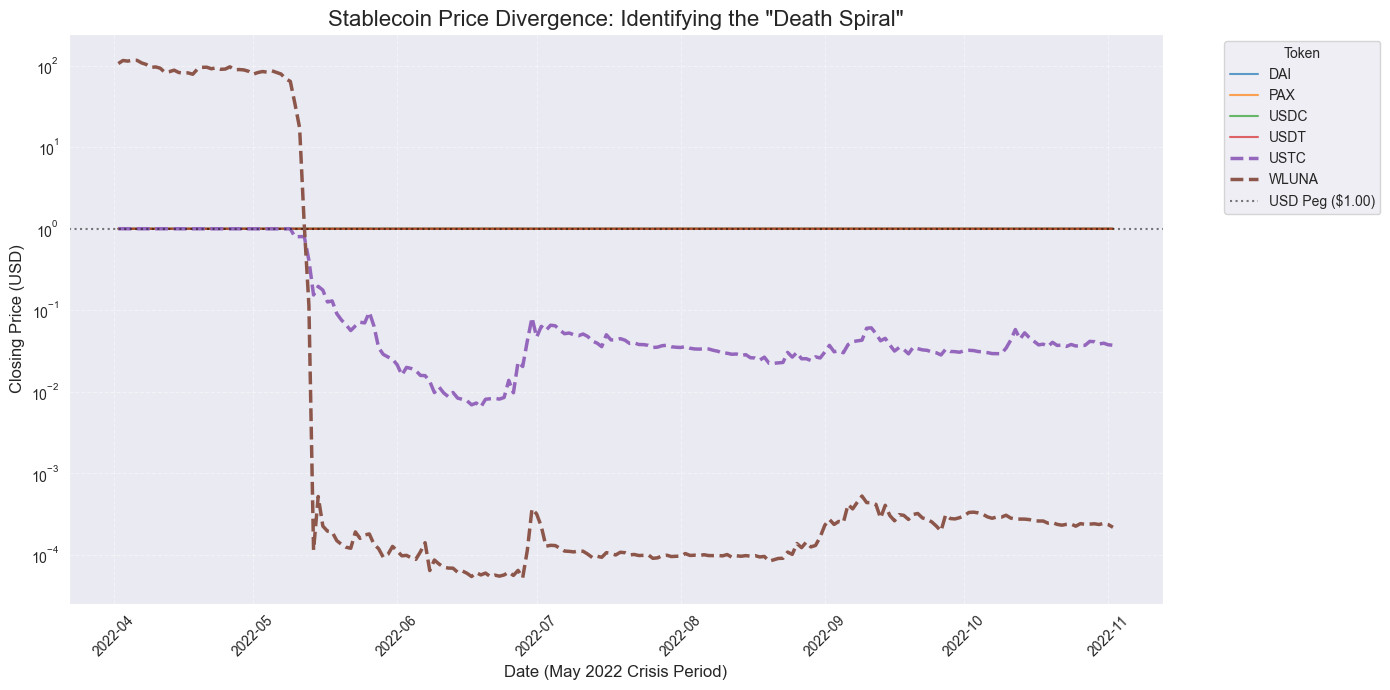

In [22]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatilit_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')

# 4. Enhance the chart
plt.title('Stablecoin Price Divergence: Identifying the "Death Spiral"', fontsize=16)
plt.xlabel('Date (May 2022 Crisis Period)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.show()

### Zoomed in to May

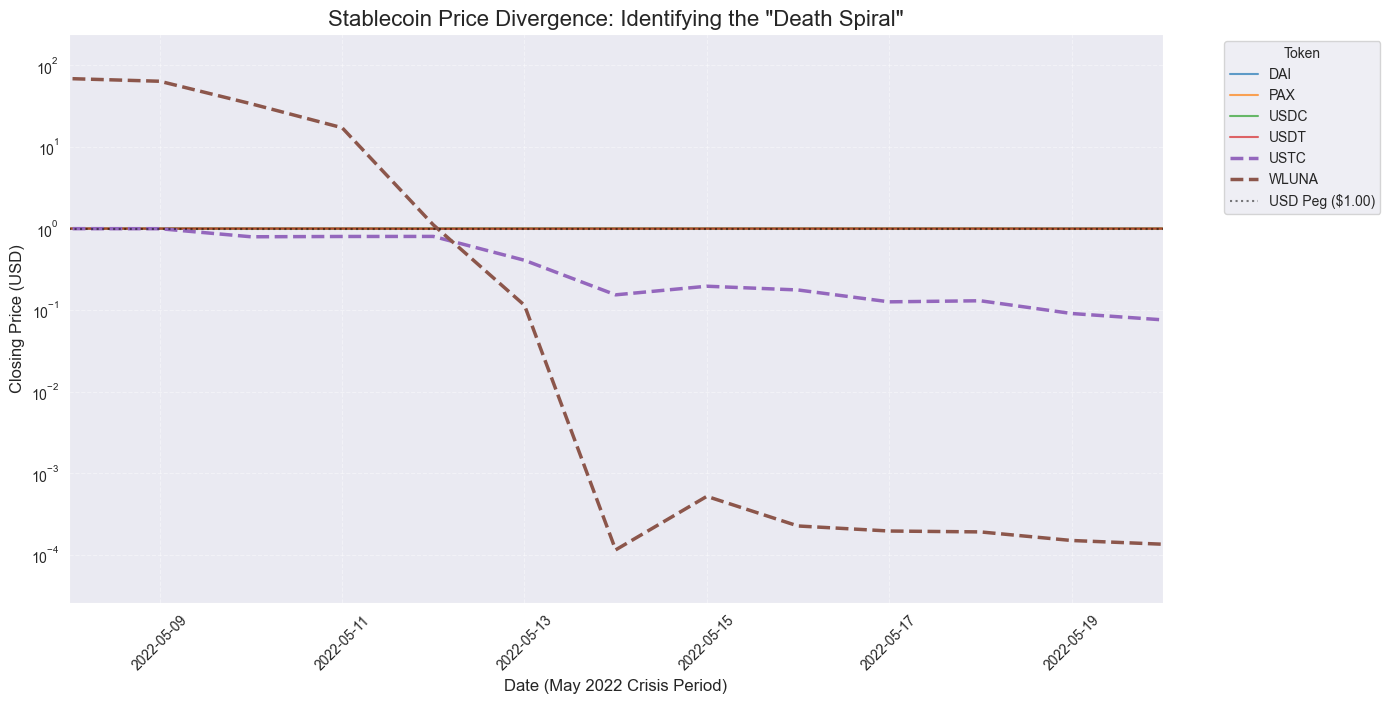

In [23]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatilit_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')


# 4. Enhance the chart
plt.title('Stablecoin Price Divergence: Identifying the "Death Spiral"', fontsize=16)
plt.xlabel('Date (May 2022 Crisis Period)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))
plt.show()

## Analysis of interday range over time

### plot of interday range against time

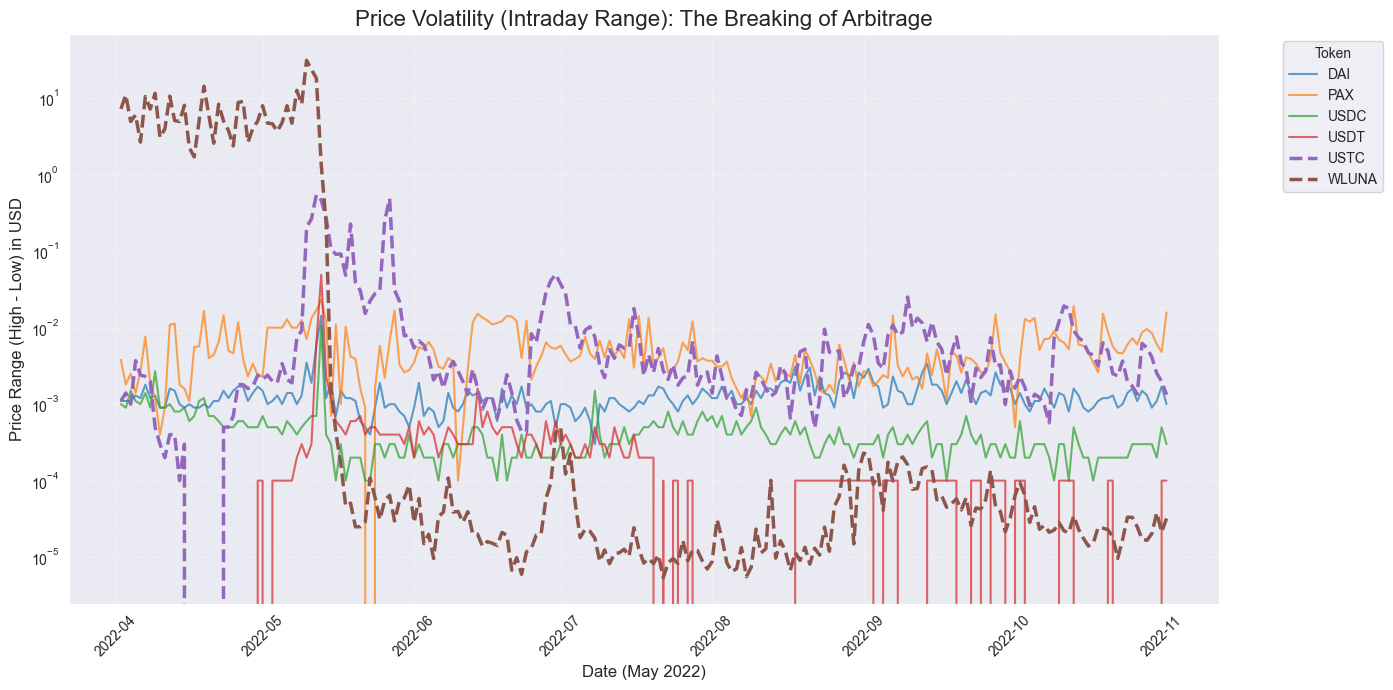

In [24]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatility_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, alpha=0.7)

# 4. Enhance the chart
plt.title('Price Volatility (Intraday Range): The Breaking of Arbitrage', fontsize=16)
plt.xlabel('Date (May 2022)', fontsize=12)
plt.ylabel('Price Range (High - Low) in USD', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.show()

### zoom into may


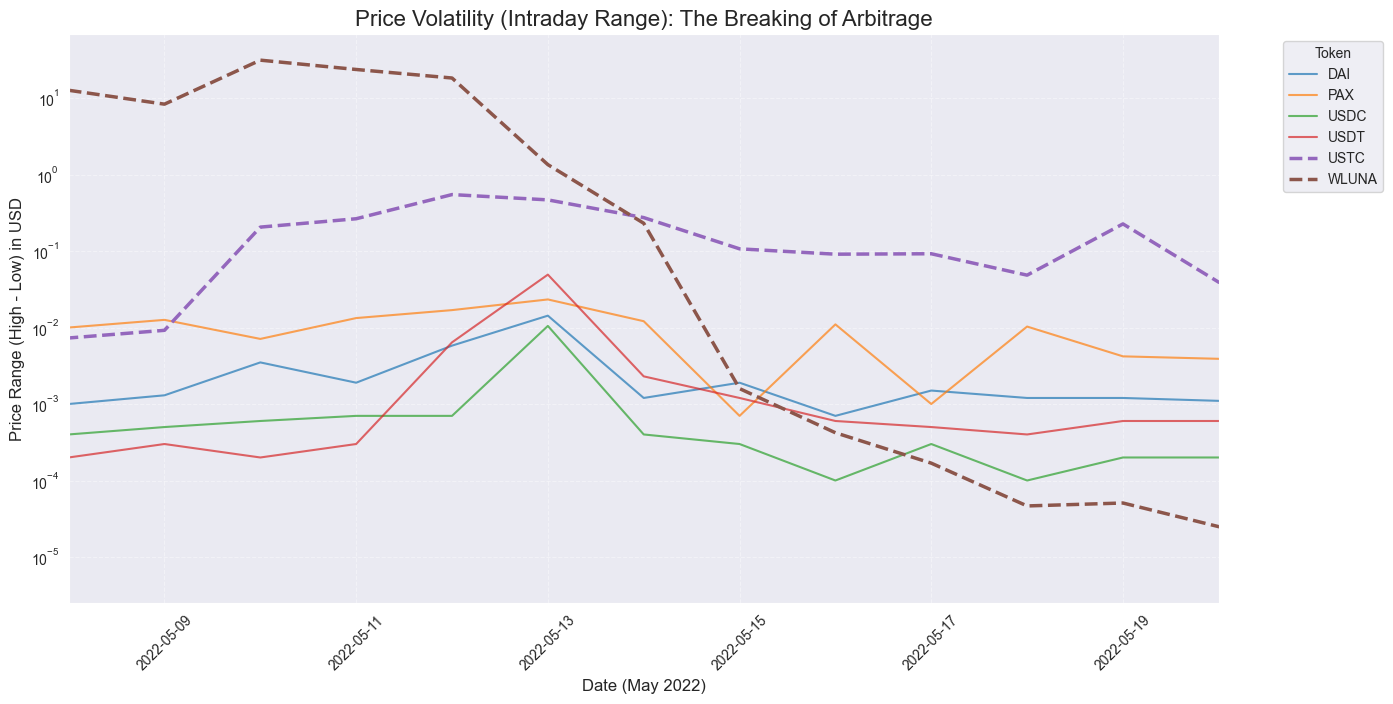

In [25]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatility_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, alpha=0.7)

# 4. Enhance the chart
plt.title('Price Volatility (Intraday Range): The Breaking of Arbitrage', fontsize=16)
plt.xlabel('Date (May 2022)', fontsize=12)
plt.ylabel('Price Range (High - Low) in USD', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))
plt.show()

# Events

In [26]:
with zipfile.ZipFile("data/ERC20-stablecoins.zip") as z:
    with z.open("event_data.csv") as f:
        EV = pd.read_csv(f, encoding='latin-1')
        print(EV)

                                                event   timestamp      type  \
0   BlackRock and Fidelity Back USDC in $400 Milli...  1649721600  positive   
1   Terra UST takes over BUSD to become third larg...  1650412800  positive   
2   LARGE amounts of UST selling on ANCHOR (approx...  1651881600  negative   
3   UST depegs LFG deploys assets to defend peg (7...  1651968000  negative   
4     UST Depegs again to 35 cents LUNA keeps falling  1652054400  negative   
5                        LUNA Collapses by almost 99%  1652313600  negative   
6   UST Downfall Brings Record Volumes to Curve: I...  1652313600  negative   
7   Terra Halts Its Blockchain and Binance Suspend...  1652400000  negative   
8      LUNA essentially worthless (1/100th of a cent)  1652486400  negative   
9   Luna Foundation Guard 80000 Bitcoin Lighter Af...  1652659200  negative   
10            Tether Token (USDT) Launches on Polygon  1653609600  positive   
11            Tether Tokens (USDT) to Launch on Tezo

In [27]:
EV['datetime'] = pd.to_datetime(EV['timestamp'], unit='s')
EV.drop(columns=['timestamp'], inplace=True)
EV.drop(columns=['event'], inplace=True)
print(EV)

        type stablecoin   datetime
0   positive       usdc 2022-04-12
1   positive       ustc 2022-04-20
2   negative       ustc 2022-05-07
3   negative       ustc 2022-05-08
4   negative       ustc 2022-05-09
5   negative  lunaterra 2022-05-12
6   negative       ustc 2022-05-12
7   negative  lunaterra 2022-05-13
8   negative  lunaterra 2022-05-14
9   negative  lunaterra 2022-05-16
10  positive       usdt 2022-05-27
11  positive       usdt 2022-06-09
12  negative    unknown 2022-06-11
13  positive        dai 2022-06-13
14  positive       usdc 2022-06-13
15  negative       usdc 2022-08-08
16  positive    unknown 2022-08-11
17  negative        dai 2022-08-11
18  negative       usdc 2022-08-22
19  positive       usdc 2022-08-31
20  positive        dai 2022-08-31
21  negative  lunaterra 2022-09-02
22  positive  lunaterra 2022-09-05
23  negative  lunaterra 2022-09-06
24  negative  lunaterra 2022-09-07
25  positive  lunaterra 2022-09-09
26  negative    unknown 2022-09-11
27  positive    unkn

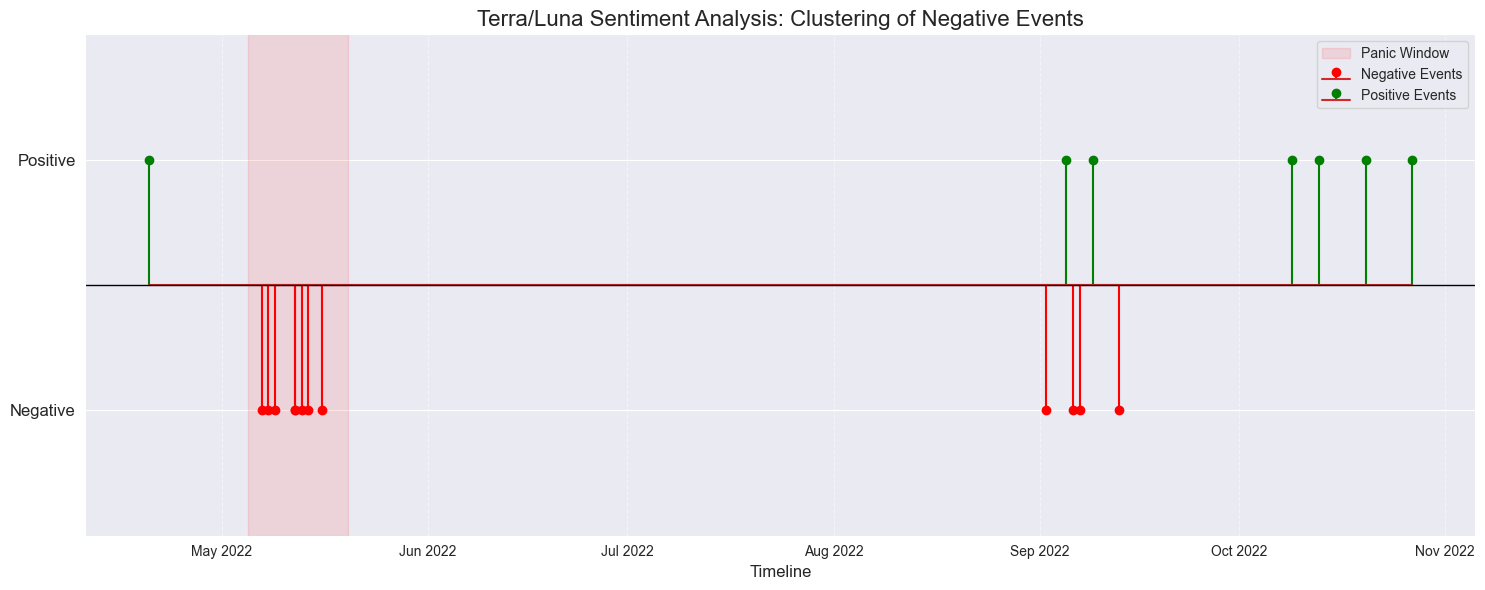

In [28]:
# 1. Filter for Terra/Luna Ecosystem only
terra_luna = EV[EV['stablecoin'].isin(['ustc', 'lunaterra'])].copy()
terra_luna = terra_luna.sort_values('datetime')
terra_luna['y'] = terra_luna['type'].map({'positive': 1, 'negative': -1})

# 2. Create the Plot
plt.figure(figsize=(15, 6))

# 3 Separate data for coloring
pos = terra_luna[terra_luna['type'] == 'positive']
neg = terra_luna[terra_luna['type'] == 'negative']

# Plot Negative events in Red
plt.stem(neg['datetime'], neg['y'], linefmt='r-', markerfmt='ro', label='Negative Events')
# Plot Positive events in Green
plt.stem(pos['datetime'], pos['y'], linefmt='g-', markerfmt='go', label='Positive Events')

# 4. Styling and Annotations
plt.axhline(0, color='black', linewidth=1) # Baseline
plt.ylim(-2, 2)
plt.yticks([-1, 1], ['Negative', 'Positive'], fontsize=12)

# Highlight the core crash period in May
plt.axvspan(pd.Timestamp('2022-05-05'), pd.Timestamp('2022-05-20'), color='red', alpha=0.1, label='Panic Window')

plt.title('Terra/Luna Sentiment Analysis: Clustering of Negative Events', fontsize=16)
plt.xlabel('Timeline', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()

# Date Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# 2008 GFC

## File loading

In [30]:
# Load all datasets
print("\n1. LOADING DATA...")
print("-"*80)

data_files = {
    'GSPC': 'data/gfc data/^GSPC.csv',
    'DJI': 'data/gfc data/^DJI.csv',
    'VIX': 'data/gfc data/^VIX.csv',
    'TEDRATE': 'data/gfc data/TEDRATE.csv',
    'WGS3MO': 'data/gfc data/WGS3MO.csv',
    'AIG': 'data/gfc data/AIG.csv',
    'C': 'data/gfc data/C.csv',
    'JPM': 'data/gfc data/JPM.csv'
}

# Load data into dictionary
data = {}
for name, filepath in data_files.items():
    if name in ['TEDRATE', 'WGS3MO']:
        # These files have different format
        df = pd.read_csv(filepath)
        df['observation_date'] = pd.to_datetime(df['observation_date'])
        df = df.set_index('observation_date')
        df = df.sort_index()
    else:
        # Stock data files have 'Price' column with dates
        df = pd.read_csv(filepath, skiprows=3)  # Skip header rows
        df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.sort_index()
        # Convert numeric columns
        for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    data[name] = df
    print(f"✓ Loaded {name}: {len(df)} records from {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")

print("\n2. DATA INSPECTION")
print("-"*80)

# Inspect first few rows of each dataset
for name, df in data.items():
    print(f"\n{name} columns: {list(df.columns)}")
    print(df.head(3))


1. LOADING DATA...
--------------------------------------------------------------------------------
✓ Loaded GSPC: 2011 records from 2005-01-04 to 2012-12-28
✓ Loaded DJI: 2011 records from 2005-01-04 to 2012-12-28
✓ Loaded VIX: 2011 records from 2005-01-04 to 2012-12-28
✓ Loaded TEDRATE: 2085 records from 2005-01-04 to 2012-12-31
✓ Loaded WGS3MO: 417 records from 2005-01-07 to 2012-12-28
✓ Loaded AIG: 2011 records from 2005-01-04 to 2012-12-28
✓ Loaded C: 2011 records from 2005-01-04 to 2012-12-28
✓ Loaded JPM: 2011 records from 2005-01-04 to 2012-12-28

2. DATA INSPECTION
--------------------------------------------------------------------------------

GSPC columns: ['Close', 'High', 'Low', 'Open', 'Volume']
                  Close         High          Low         Open      Volume
Date                                                                      
2005-01-04  1188.050049  1205.839966  1185.390015  1202.079956  1721000000
2005-01-05  1183.739990  1192.729980  1183.719971  118

## clean price functions(DJI,GSPC,AIG,C,JPM)


In [31]:
def cleanBasic(df, name):
    """
    Cleans OHLC stock data. Handles 'Date' as an index or a column.
    """
    # 1. Reset index if 'Date' is the index to allow cleaning
    if df.index.name == 'Date':
        df = df.reset_index()

    # 2. Check for Nulls in essential price columns
    initial_count = len(df)
    df = df.dropna(subset=['Date', 'Close']).copy()

    # 3. Logic Check: Low > High
    # If data is corrupted where Low is higher than High, remove it.
    anomaly_mask = df['Low'] > df['High']
    anomaly_count = anomaly_mask.sum()
    df = df[~anomaly_mask].copy()

    # 4. Final Prep: Set index back to Date and sort
    df = df.sort_values('Date').set_index('Date')

    print(f"✓ {name:<8} | Dropped: {initial_count - len(df)} (Anomalies: {anomaly_count})")
    return df

## clean VIX function

In [32]:
def clean_vix(df):
    """
    Cleans VIX data and removes the empty Volume column.
    """
    if df.index.name == 'Date':
        df = df.reset_index()

    initial_count = len(df)

    # Logic Check: Low > High
    anomaly_mask = df['Low'] > df['High']
    anomaly_count = anomaly_mask.sum()
    df = df[~anomaly_mask].copy()

    # Remove Volume (irrelevant for VIX index)
    if 'Volume' in df.columns:
        df = df.drop(columns=['Volume'])

    df = df.dropna(subset=['Date', 'Close']).sort_values('Date').set_index('Date')

    print(f"✓ VIX      | Dropped: {initial_count - len(df)} (Anomalies: {anomaly_count})")
    return df

## clean indicators

In [33]:
def clean_indicators(df, name):
    """
    Cleans TEDRATE and WGS3MO. Converts 'observation_date' to 'Date'.
    """
    # 1. Standardize index/column name to 'Date'
    if df.index.name == 'observation_date':
        df.index.name = 'Date'

    if 'observation_date' in df.columns:
        df = df.rename(columns={'observation_date': 'Date'})

    # 2. Reset index to clean
    df = df.reset_index()

    initial_count = len(df)

    # Identify the value column (TEDRATE or WGS3MO)
    val_col = [c for c in df.columns if c != 'Date'][0]

    # Remove Nulls (especially important for TEDRATE '.' values)
    df = df.dropna(subset=['Date', val_col]).copy()

    # 3. Final Prep
    df = df.sort_values('Date').set_index('Date')

    print(f"✓ {name:<8} | Dropped: {initial_count - len(df)} rows")
    return df

## data cleaning

In [34]:
print("3. CLEANING DATA...")
print("-" * 40)

for name in data:
    if name == 'VIX':
        data[name] = clean_vix(data[name])
    elif name in ['TEDRATE', 'WGS3MO']:
        data[name] = clean_indicators(data[name], name)
    else:
        # For GSPC, DJI, AIG, C, JPM
        data[name] = cleanBasic(data[name], name)

print("-" * 40)
print("✓ All datasets cleaned and indexed by 'Date'.")

3. CLEANING DATA...
----------------------------------------
✓ GSPC     | Dropped: 0 (Anomalies: 0)
✓ DJI      | Dropped: 0 (Anomalies: 0)
✓ VIX      | Dropped: 0 (Anomalies: 0)
✓ TEDRATE  | Dropped: 123 rows
✓ WGS3MO   | Dropped: 0 rows
✓ AIG      | Dropped: 0 (Anomalies: 0)
✓ C        | Dropped: 0 (Anomalies: 0)
✓ JPM      | Dropped: 0 (Anomalies: 0)
----------------------------------------
✓ All datasets cleaned and indexed by 'Date'.


## plots

### TEDRATE vs WGS (for 1b)

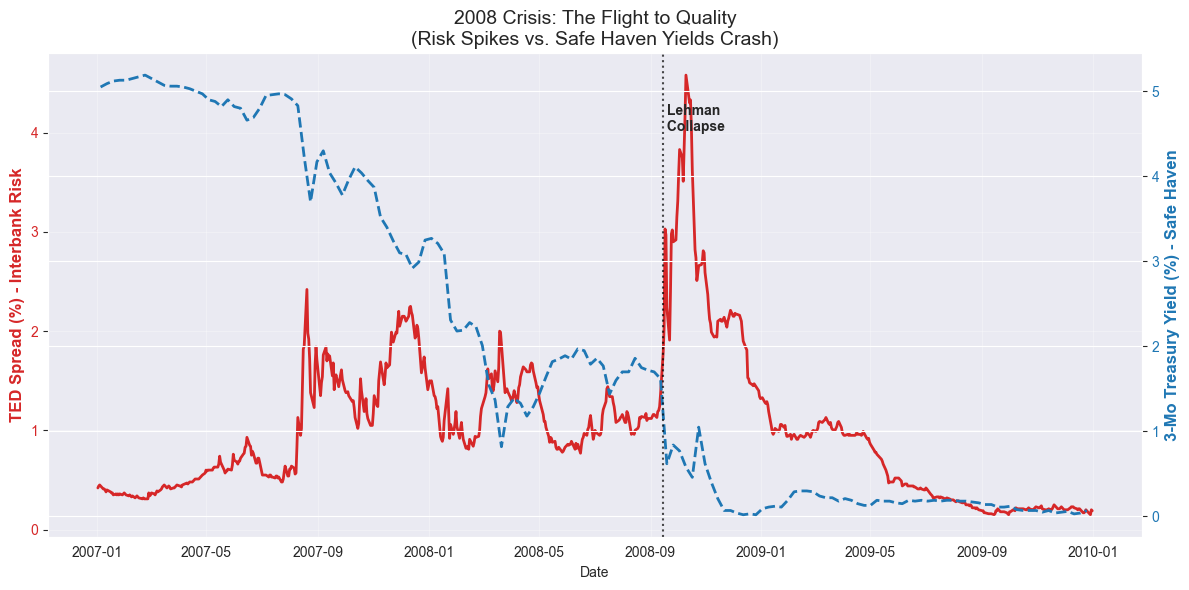

In [35]:
# 2. Filter for the GFC Period (2007 - 2009)
ted_df = data["TEDRATE"]
wgs_df = data ["WGS3MO"]

start_date = '2007-01-01'
end_date = '2009-12-31'

ted_gfc = ted_df.loc[start_date:end_date]
wgs_gfc = wgs_df.loc[start_date:end_date]

# 3. Create the Yield Divergence Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axis 1: TED Spread (Stress Indicator)
color_ted = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('TED Spread (%) - Interbank Risk', color=color_ted, fontsize=12, fontweight='bold')
ax1.plot(ted_gfc.index, ted_gfc['TEDRATE'], color=color_ted, linewidth=2, label='TED Spread')
ax1.tick_params(axis='y', labelcolor=color_ted)
ax1.grid(True, alpha=0.3)

# Axis 2: 3-Month Treasury Yield (Safe Haven)
ax2 = ax1.twinx()
color_wgs = 'tab:blue'
ax2.set_ylabel('3-Mo Treasury Yield (%) - Safe Haven', color=color_wgs, fontsize=12, fontweight='bold')
ax2.plot(wgs_gfc.index, wgs_gfc['WGS3MO'], color=color_wgs, linewidth=2, linestyle='--', label='3-Mo Treasury')
ax2.tick_params(axis='y', labelcolor=color_wgs)

# Highlight Lehman Collapse
lehman_date = pd.Timestamp('2008-09-15')
plt.axvline(lehman_date, color='black', linestyle=':', alpha=0.7)
plt.text(lehman_date, 4.5, ' Lehman\n Collapse', rotation=0, verticalalignment='bottom', fontweight='bold')

plt.title('2008 Crisis: The Flight to Quality\n(Risk Spikes vs. Safe Haven Yields Crash)', fontsize=14)
fig.tight_layout()



### bank stocks vs vix (1a)

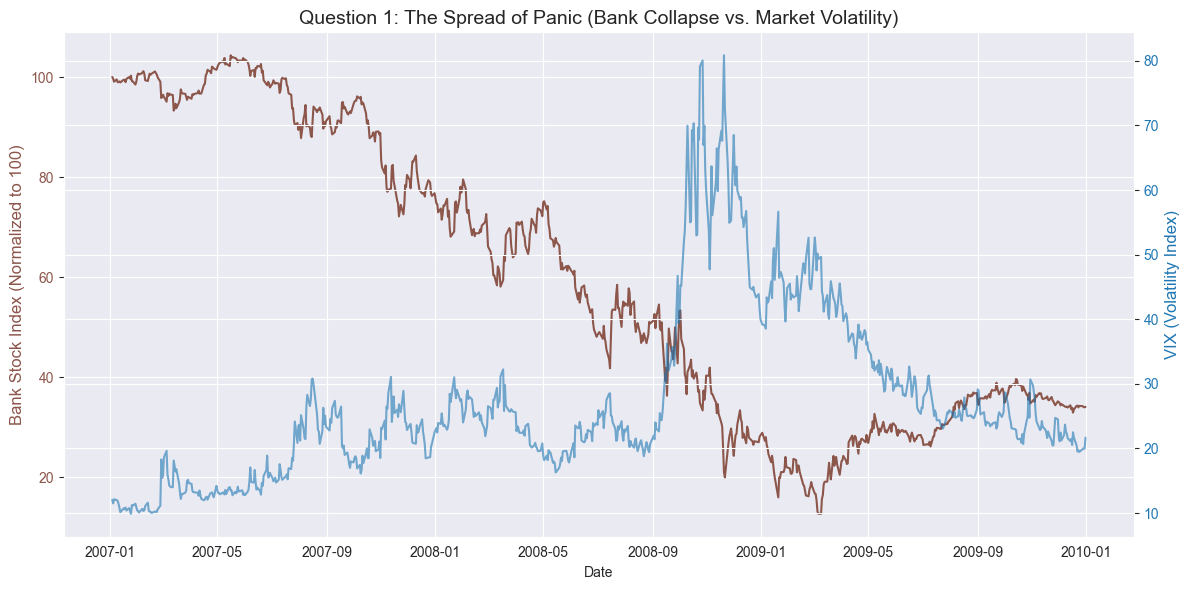

In [36]:
# Normalize to start of 2007
def norm(df):
    start_price = df.loc['2007-01-03', 'Close']
    df['Normalized'] = df['Close'] / start_price * 100
    return df['Normalized']

aig_norm = norm(data["AIG"])
c_norm = norm(data["C"])
jpm_norm = norm(data["JPM"])

# Average Bank Index
bank_index = (aig_norm + c_norm + jpm_norm) / 3

# 2. PREP VIX
vix = data["VIX"]

# 3. COMBINE
combined_fear = pd.DataFrame({'Banks': bank_index, 'VIX': vix['Close']}).dropna()
crisis_fear = combined_fear.loc['2007-01-01':'2009-12-31']

# 4. PLOT
fig, ax1 = plt.subplots(figsize=(12, 6))

color_bank = 'tab:brown'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bank Stock Index (Normalized to 100)', color=color_bank, fontsize=12)
ax1.plot(crisis_fear.index, crisis_fear['Banks'], color=color_bank, label='Major Banks (AIG, C, JPM)')
ax1.tick_params(axis='y', labelcolor=color_bank)

ax2 = ax1.twinx()
color_vix = 'tab:blue'
ax2.set_ylabel('VIX (Volatility Index)', color=color_vix, fontsize=12)
ax2.plot(crisis_fear.index, crisis_fear['VIX'], color=color_vix, alpha=0.6, label='VIX (Fear Index)')
ax2.tick_params(axis='y', labelcolor=color_vix)

plt.title('Question 1: The Spread of Panic (Bank Collapse vs. Market Volatility)', fontsize=14)
fig.tight_layout()

### corr plots (honestly can used for all 3)

Text(0.5, 1.0, '2008 Crisis Correlation Heatmap: VIX, Banks, and S&P 500')

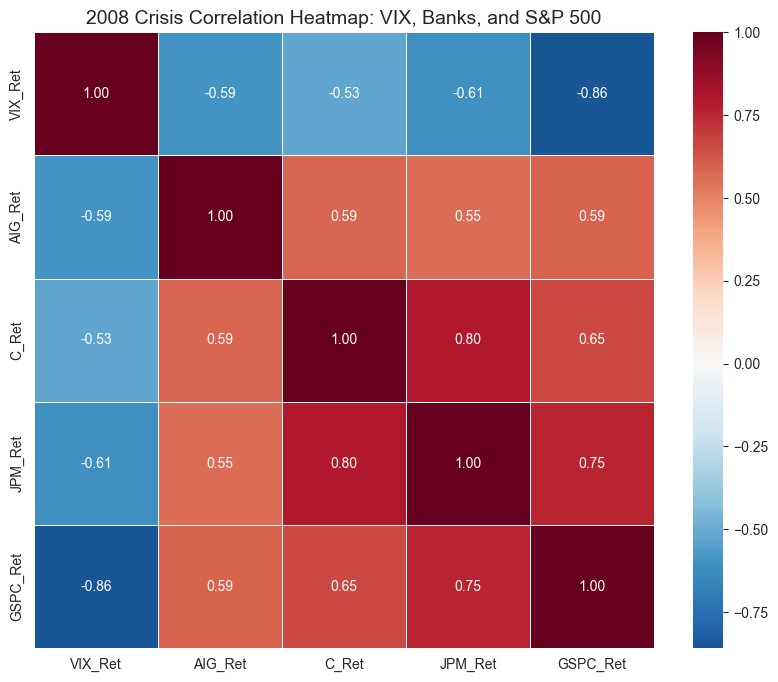

In [37]:
vix_ret  = data["VIX"]['Close'].pct_change().rename("VIX_Ret")
aig_ret  = data["AIG"]['Close'].pct_change().rename("AIG_Ret")
c_ret    = data["C"]['Close'].pct_change().rename("C_Ret")
jpm_ret  = data["JPM"]['Close'].pct_change().rename("JPM_Ret")
gspc_ret = data["GSPC"]['Close'].pct_change().rename("GSPC_Ret")

# Combine all into one dataframe
all_returns = pd.concat([vix_ret, aig_ret, c_ret, jpm_ret, gspc_ret], axis=1, join='inner')

# Filter for the year 2008 crisis period
returns_2008C = all_returns.loc['2008-09-01':'2008-12-31']

# --- PLOT 1: HEATMAP ---
plt.figure(figsize=(10, 8))
corr_matrix8 = returns_2008C.corr()
sns.heatmap(corr_matrix8, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title('2008 Crisis Correlation Heatmap: VIX, Banks, and S&P 500', fontsize=14)


Text(0.5, 1.0, '2007 Correlation Heatmap: VIX, Banks, and S&P 500')

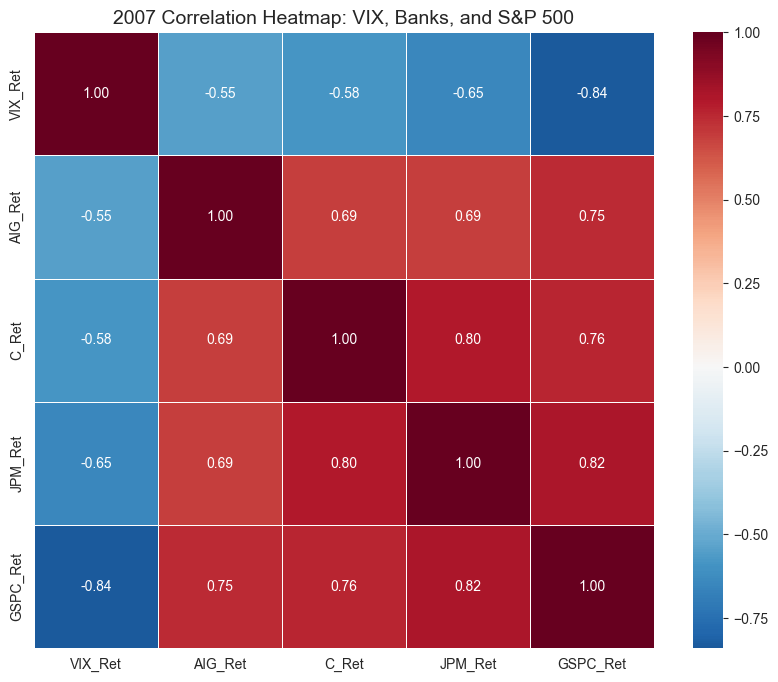

In [38]:
# Filter for the year 2007
returns_2007 = all_returns.loc['2007-01-01':'2007-12-31']

# --- PLOT 1: HEATMAP ---
plt.figure(figsize=(10, 8))
corr_matrix7 = returns_2007.corr()
sns.heatmap(corr_matrix7, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title('2007 Correlation Heatmap: VIX, Banks, and S&P 500', fontsize=14)


Text(0.5, 1.0, 'Change in Correlation: Peak Crisis vs. Pre-Crisis (P2 - P1)')

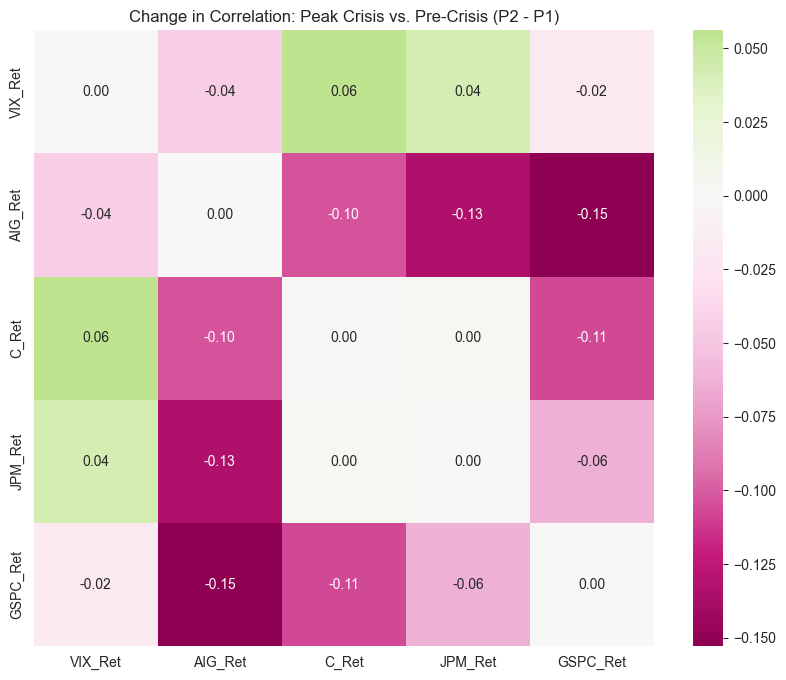

In [39]:
corr_diff = corr_matrix8 - corr_matrix7
plt.figure(figsize=(10, 8))
sns.heatmap(corr_diff, annot=True, cmap='PiYG', center=0, fmt='.2f')
plt.title('Change in Correlation: Peak Crisis vs. Pre-Crisis (P2 - P1)')

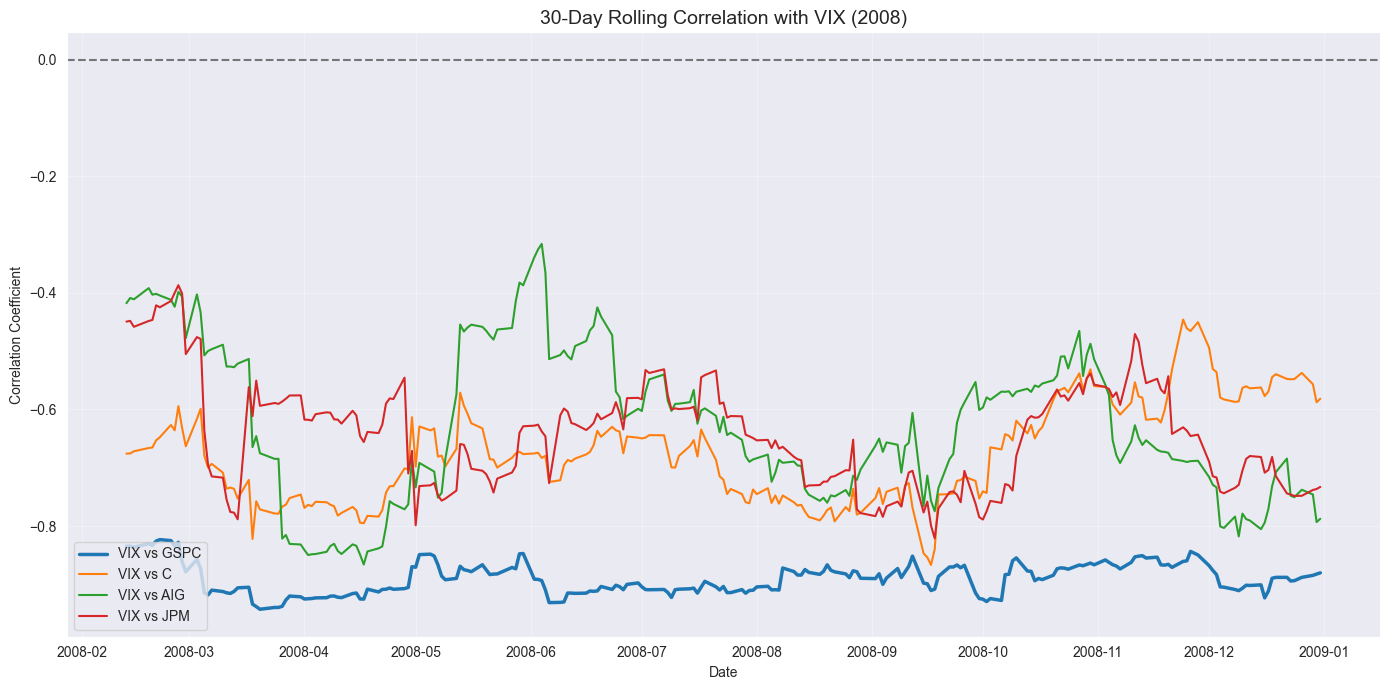

In [40]:

# Filter for the year 2008
returns_2008 = all_returns.loc['2008-01-01':'2008-12-31']


# --- PLOT 1: 30-DAY ROLLING CORRELATION ---
plt.figure(figsize=(14, 7))
window = 30

# Correlation of each asset with VIX
for ticker in ['GSPC', 'C', 'AIG', 'JPM']:
    roll_corr = returns_2008['VIX_Ret'].rolling(window=window).corr(returns_2008[f'{ticker}_Ret'])
    plt.plot(roll_corr, label=f'VIX vs {ticker}', linewidth=1.5 if ticker != 'GSPC' else 2.5)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title(f'{window}-Day Rolling Correlation with VIX (2008)', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Date')
plt.legend(loc='lower left', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()


### timelines (1a)

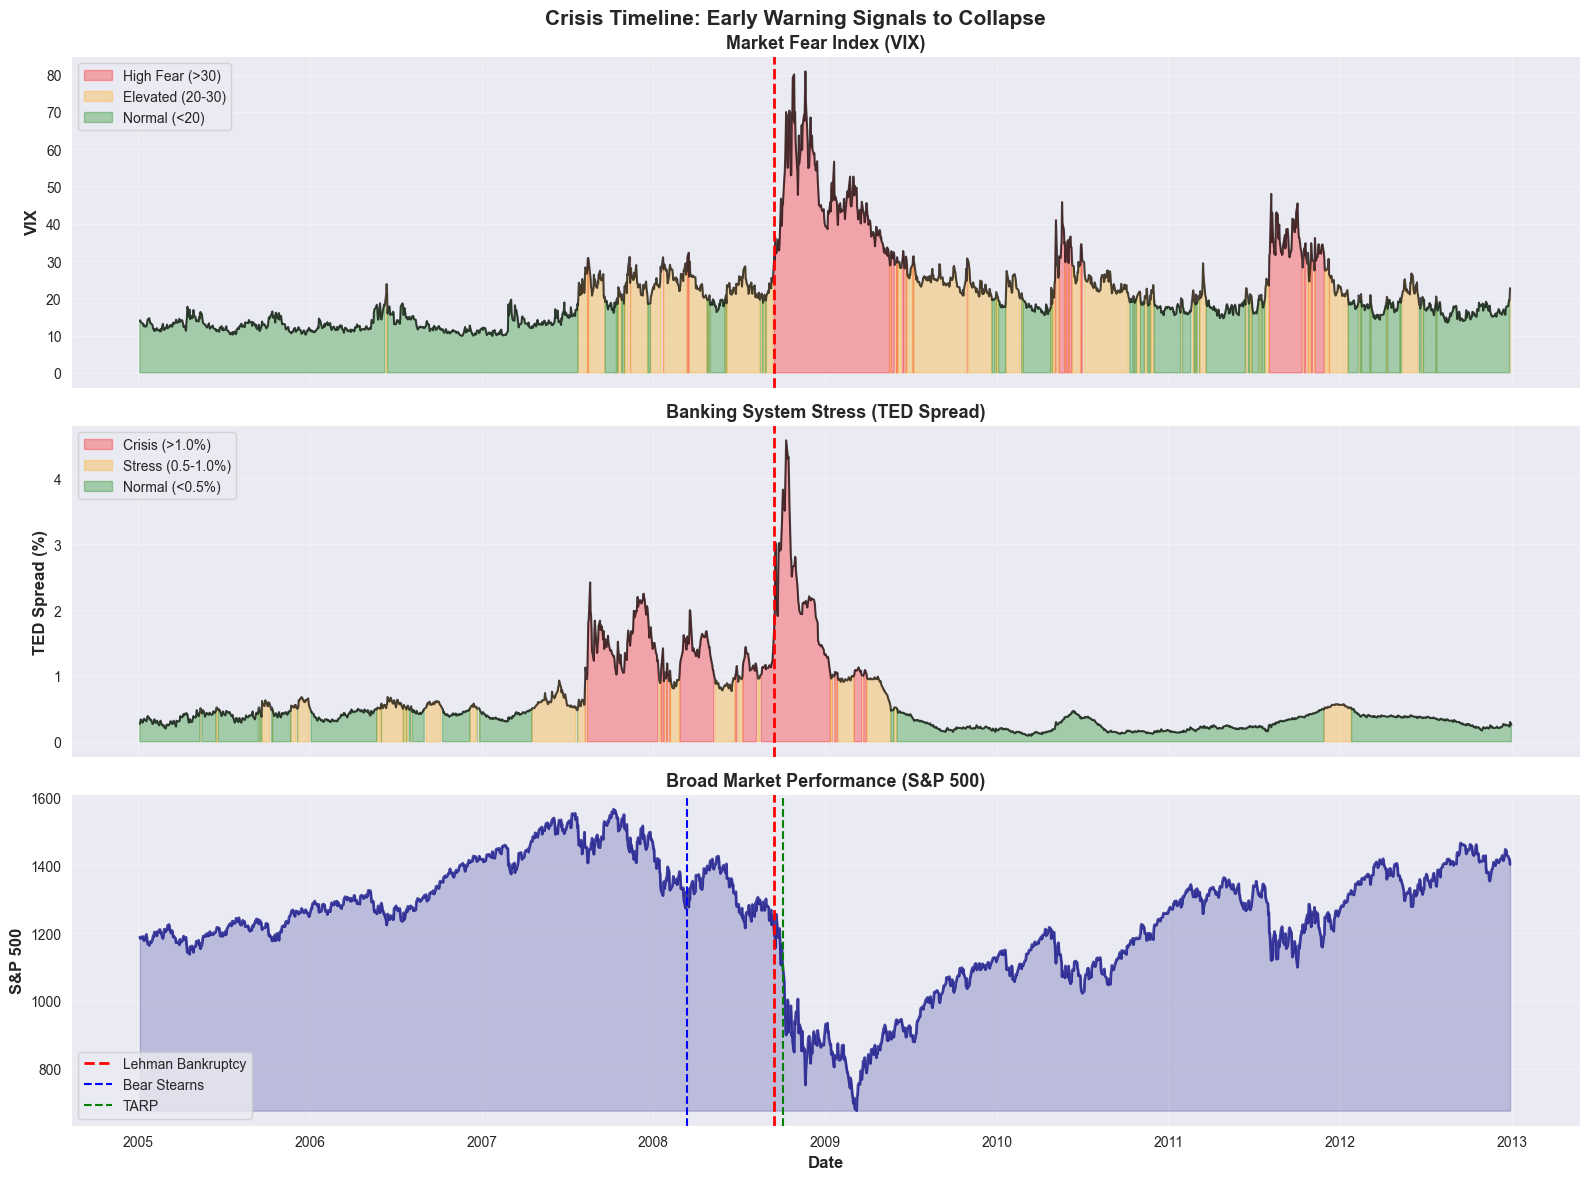

In [41]:
lehman_date = pd.to_datetime('2008-09-15')
reserve_primary_date = pd.to_datetime('2008-09-16')
bear_stearns_date = pd.to_datetime('2008-03-14')
tarp_date = pd.to_datetime('2008-10-03')
# Additional detailed plots
# Figure 2: Detailed Timeline
fig2, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# VIX with stress zones
ax = axes[0]
vix_data = data['VIX']['Close']
ax.fill_between(vix_data.index, 0, vix_data, where=(vix_data > 30), alpha=0.3, color='red', label='High Fear (>30)')
ax.fill_between(vix_data.index, 0, vix_data, where=(vix_data <= 30) & (vix_data > 20), alpha=0.3, color='orange', label='Elevated (20-30)')
ax.fill_between(vix_data.index, 0, vix_data, where=(vix_data <= 20), alpha=0.3, color='green', label='Normal (<20)')
ax.plot(vix_data.index, vix_data, color='black', linewidth=1.5, alpha=0.7)
ax.axvline(lehman_date, color='red', linestyle='--', linewidth=2)
ax.set_ylabel('VIX', fontsize=12, fontweight='bold')
ax.set_title('Market Fear Index (VIX)', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# TED Spread
ax = axes[1]
ted_data = data['TEDRATE']['TEDRATE']
ax.fill_between(ted_data.index, 0, ted_data, where=(ted_data > 1.0), alpha=0.3, color='red', label='Crisis (>1.0%)')
ax.fill_between(ted_data.index, 0, ted_data, where=(ted_data <= 1.0) & (ted_data > 0.5), alpha=0.3, color='orange', label='Stress (0.5-1.0%)')
ax.fill_between(ted_data.index, 0, ted_data, where=(ted_data <= 0.5), alpha=0.3, color='green', label='Normal (<0.5%)')
ax.plot(ted_data.index, ted_data, color='black', linewidth=1.5, alpha=0.7)
ax.axvline(lehman_date, color='red', linestyle='--', linewidth=2)
ax.set_ylabel('TED Spread (%)', fontsize=12, fontweight='bold')
ax.set_title('Banking System Stress (TED Spread)', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# S&P 500
ax = axes[2]
sp500_data = data['GSPC']['Close']
ax.plot(sp500_data.index, sp500_data, color='navy', linewidth=2, alpha=0.7)
ax.axvline(lehman_date, color='red', linestyle='--', linewidth=2, label='Lehman Bankruptcy')
ax.axvline(bear_stearns_date, color='blue', linestyle='--', linewidth=1.5, label='Bear Stearns')
ax.axvline(tarp_date, color='green', linestyle='--', linewidth=1.5, label='TARP')
ax.fill_between(sp500_data.index, sp500_data.min(), sp500_data, alpha=0.2, color='navy')
ax.set_ylabel('S&P 500', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_title('Broad Market Performance (S&P 500)', fontsize=13, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.suptitle('Crisis Timeline: Early Warning Signals to Collapse', fontsize=15, fontweight='bold')
plt.tight_layout()

### individual bank stocks (1C)

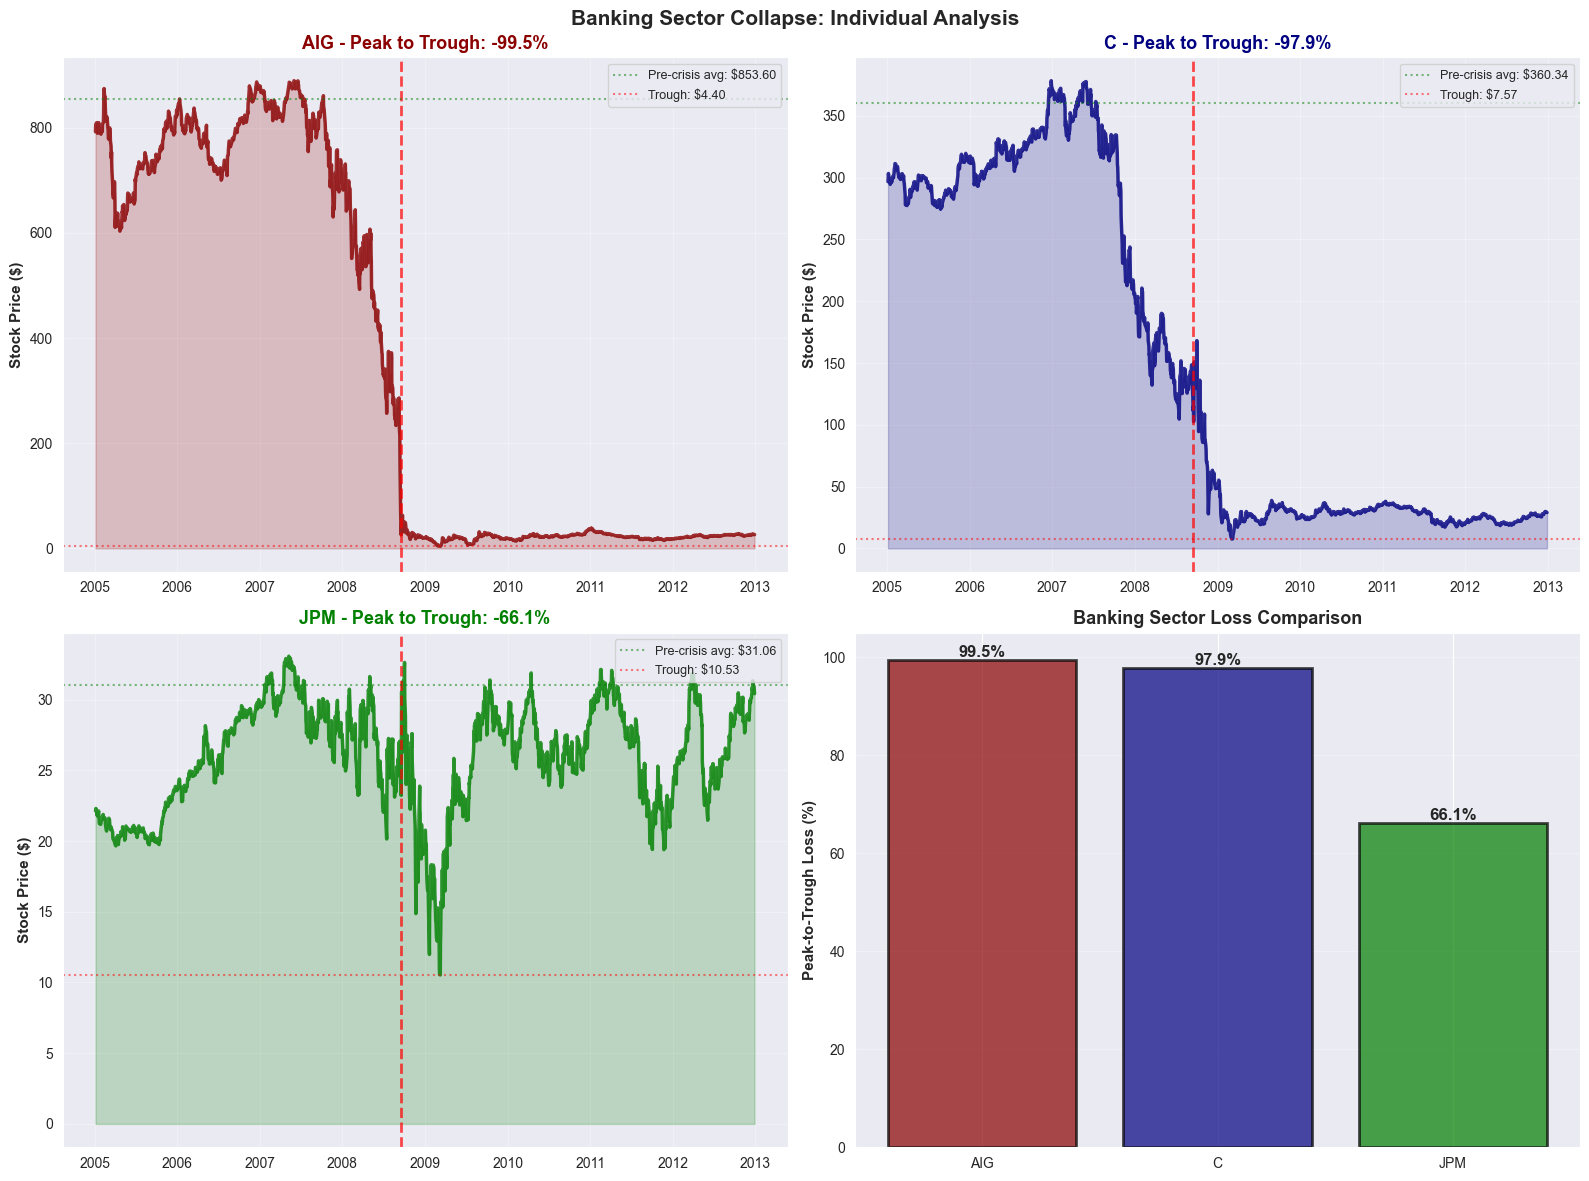

In [42]:
# Figure 3: Banking Sector Comparison
fig3, axes = plt.subplots(2, 2, figsize=(16, 12))

# Individual bank charts
banks = [('AIG', 'darkred'), ('C', 'navy'), ('JPM', 'green')]
for idx, (bank, color) in enumerate(banks):
    ax = axes[idx // 2, idx % 2]
    bank_data = data[bank]['Close']

    ax.plot(bank_data.index, bank_data, color=color, linewidth=2.5, alpha=0.8)
    ax.fill_between(bank_data.index, 0, bank_data, alpha=0.2, color=color)
    ax.axvline(lehman_date, color='red', linestyle='--', linewidth=2, alpha=0.7)

    # Mark pre-crisis avg and trough
    pre_crisis_avg = bank_data['2007-01':'2007-06'].mean()
    trough = bank_data.min()
    ax.axhline(pre_crisis_avg, color='green', linestyle=':', alpha=0.5, label=f'Pre-crisis avg: ${pre_crisis_avg:.2f}')
    ax.axhline(trough, color='red', linestyle=':', alpha=0.5, label=f'Trough: ${trough:.2f}')

    loss_pct = ((trough - pre_crisis_avg) / pre_crisis_avg) * 100

    ax.set_ylabel('Stock Price ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'{bank} - Peak to Trough: {loss_pct:.1f}%', fontsize=13, fontweight='bold', color=color)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Summary comparison
ax = axes[1, 1]
summary_data = []
for bank, _ in banks:
    bank_prices = data[bank]['Close']
    pre_crisis_avg = bank_prices['2007-01':'2007-06'].mean()
    trough = bank_prices.min()
    loss_pct = ((trough - pre_crisis_avg) / pre_crisis_avg) * 100
    summary_data.append({'Bank': bank, 'Loss (%)': abs(loss_pct)})

summary_df = pd.DataFrame(summary_data)
bars = ax.bar(summary_df['Bank'], summary_df['Loss (%)'], color=['darkred', 'navy', 'green'], alpha=0.7, edgecolor='black', linewidth=2)

for bar, value in zip(bars, summary_df['Loss (%)']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Peak-to-Trough Loss (%)', fontsize=11, fontweight='bold')
ax.set_title('Banking Sector Loss Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 105)

plt.suptitle('Banking Sector Collapse: Individual Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()


# Asian currency evaluation(Q2)

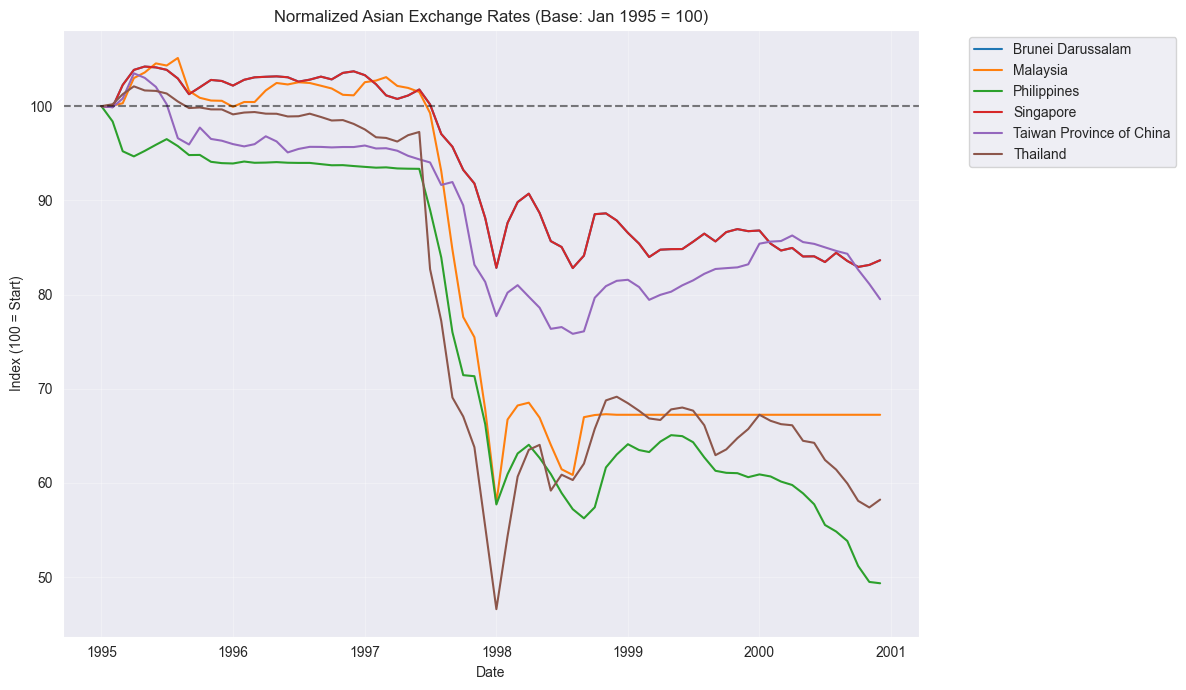

In [43]:
# Load the data
df_asian = pd.read_csv('data/Asian_curr_IMF.csv')

# Identify id columns and date columns
id_vars = ['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'SCALE']
date_cols = [col for col in df_asian.columns if col not in id_vars]

# Melt the dataframe
df_melted = df_asian.melt(id_vars=id_vars, value_vars=date_cols, var_name='Date', value_name='Exchange_Rate')

# Clean Date and convert to datetime
df_melted['Date_dt'] = pd.to_datetime(df_melted['Date'].str.replace('-M', '-'), format='%Y-%m')

# Ensure data is sorted
df_melted = df_melted.sort_values(['COUNTRY', 'Date_dt'])

# Normalize: Group by country and divide each Exchange_Rate by the first value in that group
# Using transform to avoid apply issues
df_melted['First_Value'] = df_melted.groupby('COUNTRY')['Exchange_Rate'].transform('first')
df_melted['Normalized_Rate'] = (df_melted['Exchange_Rate'] / df_melted['First_Value']) * 100

# Plotting
plt.figure(figsize=(12, 7))
for country, group in df_melted.groupby('COUNTRY'):
    plt.plot(group['Date_dt'], group['Normalized_Rate'], label=country)

plt.axhline(100, color='black', linestyle='--', alpha=0.5)
plt.title('Normalized Asian Exchange Rates (Base: Jan 1995 = 100)')
plt.xlabel('Date')
plt.ylabel('Index (100 = Start)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# citations

@inproceedings{chartalistNeurips2022,
  author    = {Kiarash Shamsi and Yulia R. Gel and  Murat Kantarcioglu and Cuneyt G. Akcora},
  title     = {Chartalist: Labeled Graph Datasets for UTXO and Account-based Blockchains},
  booktitle = {Advances in Neural Information Processing Systems 36: Annual Conference on Neural Information Processing Systems 2022, NeurIPS 2022, November 29-December 1, 2022, New Orleans, LA, USA},
  pages     = {1--14},
  year      = {2022},
  url       = {https://openreview.net/pdf?id=10iA3OowAV3}
  }